In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime
import scipy.stats

In [2]:
df_commodities = pd.read_csv("COMMODITIES.csv")

In [3]:
df_commodities = df_commodities[df_commodities["FREQUENCY"] != "15min"]


In [4]:
df_forex = pd.read_csv("FOREX.csv")
df_indices = pd.read_csv("INDICES.csv")
df_cryptos = pd.read_csv("CRYPTOS.csv")

In [5]:
# Definir la lista de DataFrames
dataframes = [df_indices, df_forex, df_cryptos, df_commodities]

# Definir las columnas deseadas
columnas_seleccionadas = ["BASE_CURRENCY", "TYPE", "DATE", "DATETIME", "CLOSE", "SYMBOL"]

# Crear una lista vacía para almacenar los resultados filtrados
df_filtrados = []

# Bucle for para iterar sobre los DataFrames
for df in dataframes:
    # Filtrar las columnas seleccionadas
    df_filtrado = df[columnas_seleccionadas]
    
    # Asegurarse de que la columna DATETIME esté en formato datetime
    df_filtrado['DATETIME'] = pd.to_datetime(df_filtrado['DATETIME'])
    
    # Ordenar los datos por DATETIME para asegurarnos de tener el último registro al final
    df_filtrado = df_filtrado.sort_values(by='DATETIME')
    
    # Filtrar el último registro de cada día para cada SYMBOL
    df_ultimo_symbol = df_filtrado.groupby(['SYMBOL', 'DATE']).tail(1)
    
    # Agregar el resultado filtrado a la lista
    df_filtrados.append(df_ultimo_symbol)

# Concatenar los resultados de los tres DataFrames en uno solo
df_final = pd.concat(df_filtrados)

# Mostrar el DataFrame final
print(df_final)


C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\2444581205.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['DATETIME'] = pd.to_datetime(df_filtrado['DATETIME'])
C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\2444581205.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['DATETIME'] = pd.to_datetime(df_filtrado['DATETIME'])
C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\2444581205.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

       BASE_CURRENCY         TYPE        DATE            DATETIME  \
20567            USD      indices  2021-09-15 2021-09-15 06:00:00   
34               USD      indices  2021-09-15 2021-09-15 15:30:00   
70344            USD      indices  2021-09-15 2021-09-15 15:30:00   
34241            USD      indices  2021-09-15 2021-09-15 15:30:00   
106416           USD      indices  2021-09-15 2021-09-15 19:45:00   
...              ...          ...         ...                 ...   
24817            USD  COMMODITIES  2023-12-28 2023-12-28 00:00:00   
1832             USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
11995            USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
23277            USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
16663            USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   

               CLOSE       SYMBOL  
20567   30511.710938    Nikkei225  
34       8635.400391       IBEX35  
70344    4145.939941  EuroStoxx50  
34241   15616.000000       

C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\2444581205.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['DATETIME'] = pd.to_datetime(df_filtrado['DATETIME'])


In [6]:
# 1. Filtrar el DataFrame para obtener los registros del símbolo XBTUSD
df_BTC_symbol = df_final[df_final['SYMBOL'] == 'XBTUSD'].copy()

# 2. Renombrar la columna 'CLOSE' a 'label' para usarla más adelante
df_BTC_symbol = df_BTC_symbol[['DATE', 'CLOSE']].rename(columns={'CLOSE': 'label'})

# 3. Realizar un merge con el df_final, usando la columna DATE para emparejar los valores
df_BTC = pd.merge(df_final, df_BTC_symbol, on='DATE', how='left')

# 4. Filtrar de nuevo si solo quieres quedarte con los registros de BTC
df_BTC = df_BTC[df_BTC['SYMBOL'] != 'XBTUSD'].reset_index(drop=True)

# Mostrar el resultado
print(df_BTC)

      BASE_CURRENCY         TYPE        DATE            DATETIME  \
0               USD      indices  2021-09-15 2021-09-15 06:00:00   
1               USD      indices  2021-09-15 2021-09-15 15:30:00   
2               USD      indices  2021-09-15 2021-09-15 15:30:00   
3               USD      indices  2021-09-15 2021-09-15 15:30:00   
4               USD      indices  2021-09-15 2021-09-15 19:45:00   
...             ...          ...         ...                 ...   
15221           USD  COMMODITIES  2023-12-28 2023-12-28 00:00:00   
15222           USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
15223           USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
15224           USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
15225           USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   

              CLOSE       SYMBOL    label  
0      30511.710938    Nikkei225  48152.3  
1       8635.400391       IBEX35  48152.3  
2       4145.939941  EuroStoxx50  48152.3  
3      

In [7]:
# 1. Usar pivot_table para transformar el DataFrame
df_pivot_BTC = df_BTC.pivot_table(index='DATE', columns='SYMBOL', values='CLOSE')

# 2. renombrar las columnas para que sean más claras
df_pivot_BTC.columns = [f'{col}_CLOSE' for col in df_pivot_BTC.columns]

# 3. Añadir la columna 'label' al DataFrame df_BTC
df_labels = df_BTC[['DATE', 'label']].drop_duplicates()

# 4. Hacer un merge para combinar los datos pivotados con la columna 'label'
df_pivot_BTC = df_pivot_BTC.reset_index()
df_final_BTC = pd.merge(df_pivot_BTC, df_labels, on='DATE', how='left')

# 5. Rellenar valores faltantes usando backward fill
df_final_BTC = df_final_BTC.fillna(method='bfill')


C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\892477961.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final_BTC = df_final_BTC.fillna(method='bfill')


In [8]:
df_final_BTC.head()

,DATE,BZUSD_CLOSE,CLUSD_CLOSE,DAX_CLOSE,DowJones_CLOSE,ETHUSD_CLOSE,EuroStoxx50_CLOSE,GCUSD_CLOSE,IBEX35_CLOSE,LINKUSD_CLOSE,...,Nasdaq_CLOSE,Nikkei225_CLOSE,SP500_CLOSE,USDCHF_CLOSE,USDEUR_CLOSE,USDGBP_CLOSE,USDJPY_CLOSE,USDTUSD_CLOSE,XDGUSD_CLOSE,label
0,2021-01-01,51.09,47.62,15616.0,34814.128906,730.85,4145.939941,1946.6,8635.400391,11.87019,...,15503.533203,30511.710938,4480.700195,0.88409,0.82170,0.73130,102.996,1.0024,0.005708,29398.9
1,2021-01-02,51.09,47.62,15616.0,34814.128906,775.01,4145.939941,1946.6,8635.400391,12.20905,...,15503.533203,30511.710938,4480.700195,0.88409,0.81639,0.73092,102.996,1.0009,0.010578,32238.8
2,2021-01-03,51.09,47.62,15616.0,34814.128906,979.86,4145.939941,1946.6,8635.400391,13.69552,...,15503.533203,30511.710938,4480.700195,0.88409,0.81639,0.73092,102.996,1.0013,0.009846,33082.7
3,2021-01-04,51.09,47.62,15616.0,34814.128906,1042.52,4145.939941,1946.6,8635.400391,13.62239,...,15503.533203,30511.710938,4480.700195,0.88125,0.81486,0.73598,102.993,1.0007,0.009792,32048.0
4,2021-01-05,53.60,49.93,15616.0,34814.128906,1103.41,4145.939941,1954.4,8635.400391,14.54549,...,15503.533203,30511.710938,4480.700195,0.87872,0.81334,0.73471,102.820,1.0028,0.010000,34050.0


In [9]:
# Convertir la columna DATE a formato datetime si aún no lo está
df_final_BTC['DATE'] = pd.to_datetime(df_final_BTC['DATE'])

# Definir la fecha de corte
fecha_corte = pd.Timestamp('2021-09-06')

# Filtrar el DataFrame para quedarnos solo con los registros posteriores a la fecha de corte
df_filtered_BTC = df_final_BTC[df_final_BTC['DATE'] > fecha_corte]

In [10]:
df_filtered_BTC.head()

,DATE,BZUSD_CLOSE,CLUSD_CLOSE,DAX_CLOSE,DowJones_CLOSE,ETHUSD_CLOSE,EuroStoxx50_CLOSE,GCUSD_CLOSE,IBEX35_CLOSE,LINKUSD_CLOSE,...,Nasdaq_CLOSE,Nikkei225_CLOSE,SP500_CLOSE,USDCHF_CLOSE,USDEUR_CLOSE,USDGBP_CLOSE,USDJPY_CLOSE,USDTUSD_CLOSE,XDGUSD_CLOSE,label
249,2021-09-07,71.69,68.35,15616.0,34814.128906,3432.33,4145.939941,1795.90002,8635.400391,28.24024,...,15503.533203,30511.710938,4480.700195,0.91930,0.844309,0.72570,110.289,1.0004,0.254971,46882.1
250,2021-09-08,72.60,69.30,15616.0,34814.128906,3500.00,4145.939941,1793.50000,8635.400391,27.14759,...,15503.533203,30511.710938,4480.700195,0.92065,0.846095,0.72647,110.192,1.0002,0.256860,46073.4
251,2021-09-09,71.45,68.14,15616.0,34814.128906,3423.99,4145.939941,1800.00000,8635.400391,27.97549,...,15503.533203,30511.710938,4480.700195,0.91659,0.845260,0.72194,109.867,1.0002,0.252466,46389.6
252,2021-09-10,72.92,69.72,15616.0,34814.128906,3206.93,4145.939941,1792.10000,8635.400391,26.37962,...,15503.533203,30511.710938,4480.700195,0.91800,0.846680,0.72270,109.905,1.0000,0.239508,44842.2
253,2021-09-11,73.51,70.45,15616.0,34814.128906,3265.83,4145.939941,1794.40000,8635.400391,26.98446,...,15503.533203,30511.710938,4480.700195,0.91814,0.846600,0.72250,109.914,1.0002,0.240987,45137.4


In [11]:
df_filtered_BTC.shape

(846, 21)

<Axes: title={'center': 'BRENT'}>

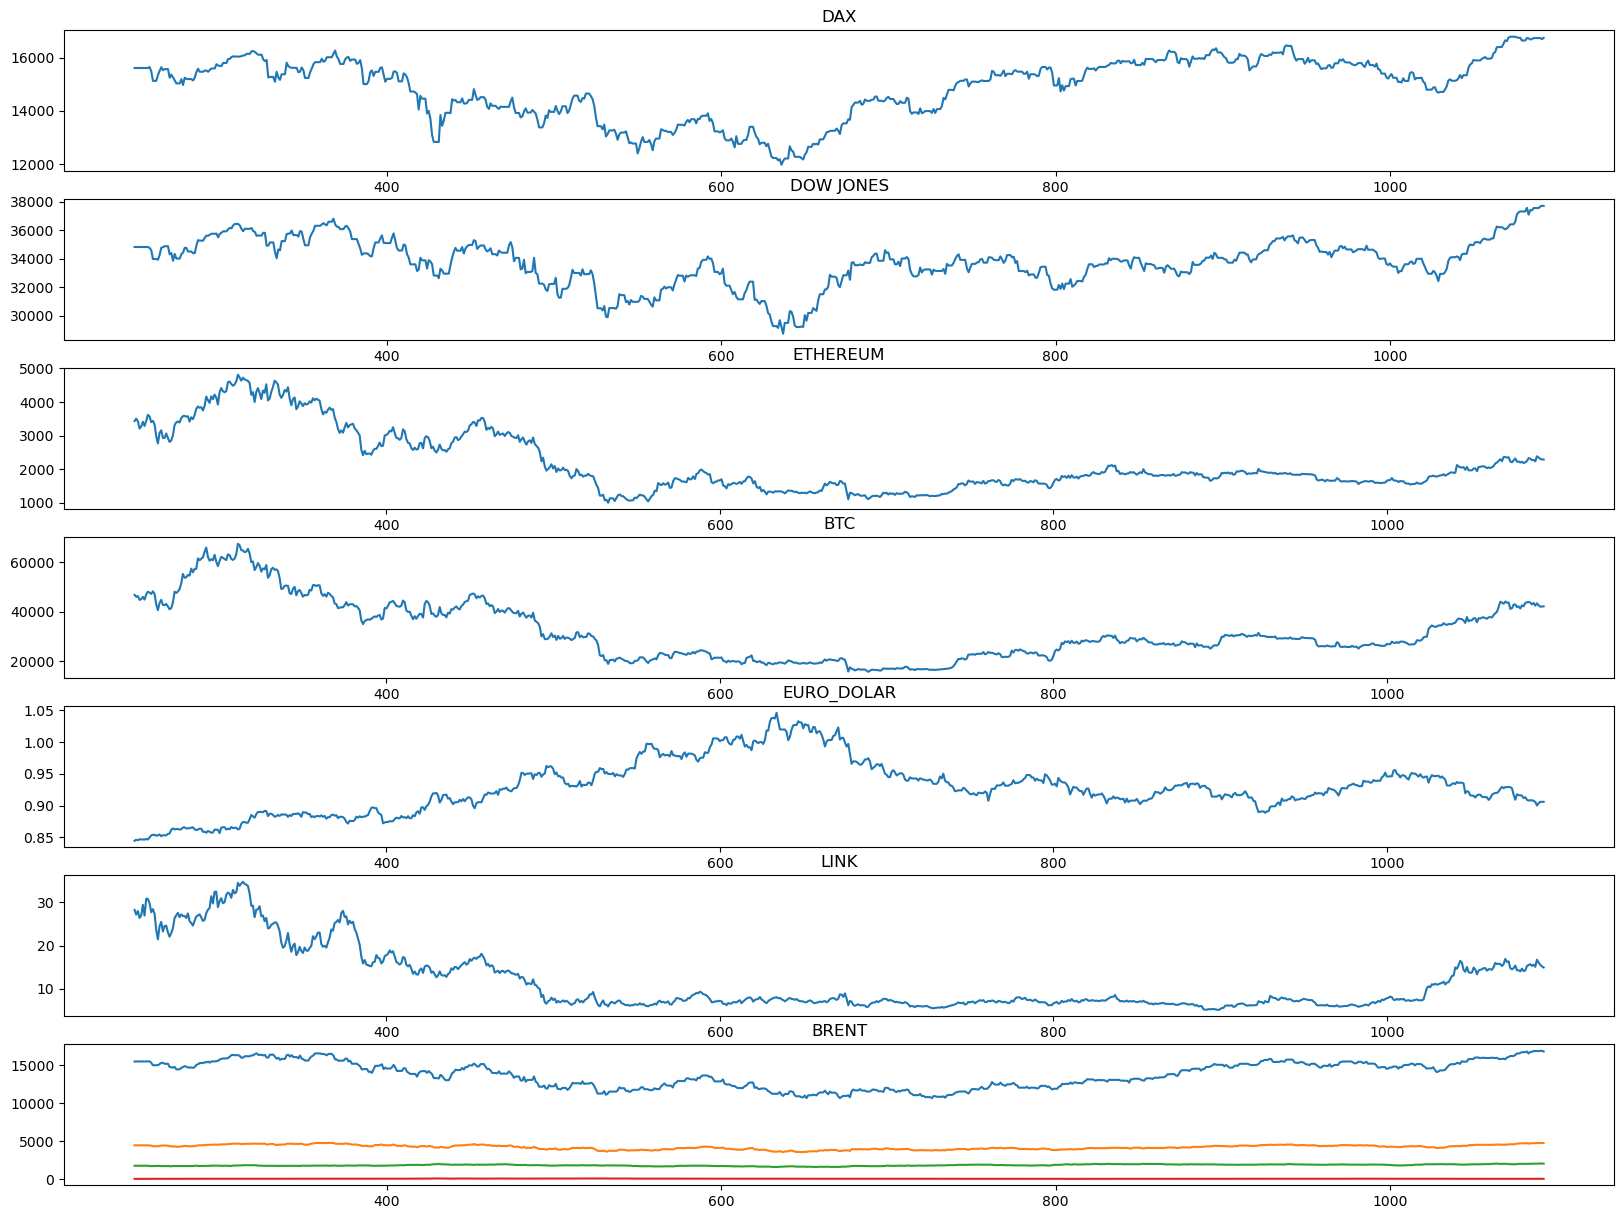

In [12]:
fig, axs = plt.subplots(ncols=1, nrows=7,figsize=(20, 15))
df_filtered_BTC.DAX_CLOSE.plot(ax=axs[0], title = "DAX")
df_filtered_BTC.DowJones_CLOSE.plot(ax=axs[1], title = "DOW JONES")
df_filtered_BTC.ETHUSD_CLOSE.plot(ax=axs[2], title = "ETHEREUM")
df_filtered_BTC.label.plot(ax=axs[3], title = "BTC")
df_filtered_BTC.USDEUR_CLOSE.plot(ax=axs[4], title = "EURO_DOLAR")
df_filtered_BTC.LINKUSD_CLOSE.plot(ax=axs[5], title = "LINK")
df_filtered_BTC.Nasdaq_CLOSE.plot(ax=axs[6], title = "NASDAQ")
df_filtered_BTC.SP500_CLOSE.plot(ax=axs[6], title = "SP500")
df_filtered_BTC.GCUSD_CLOSE.plot(ax=axs[6], title = "ORO")
df_filtered_BTC.BZUSD_CLOSE.plot(ax=axs[6], title = "BRENT")

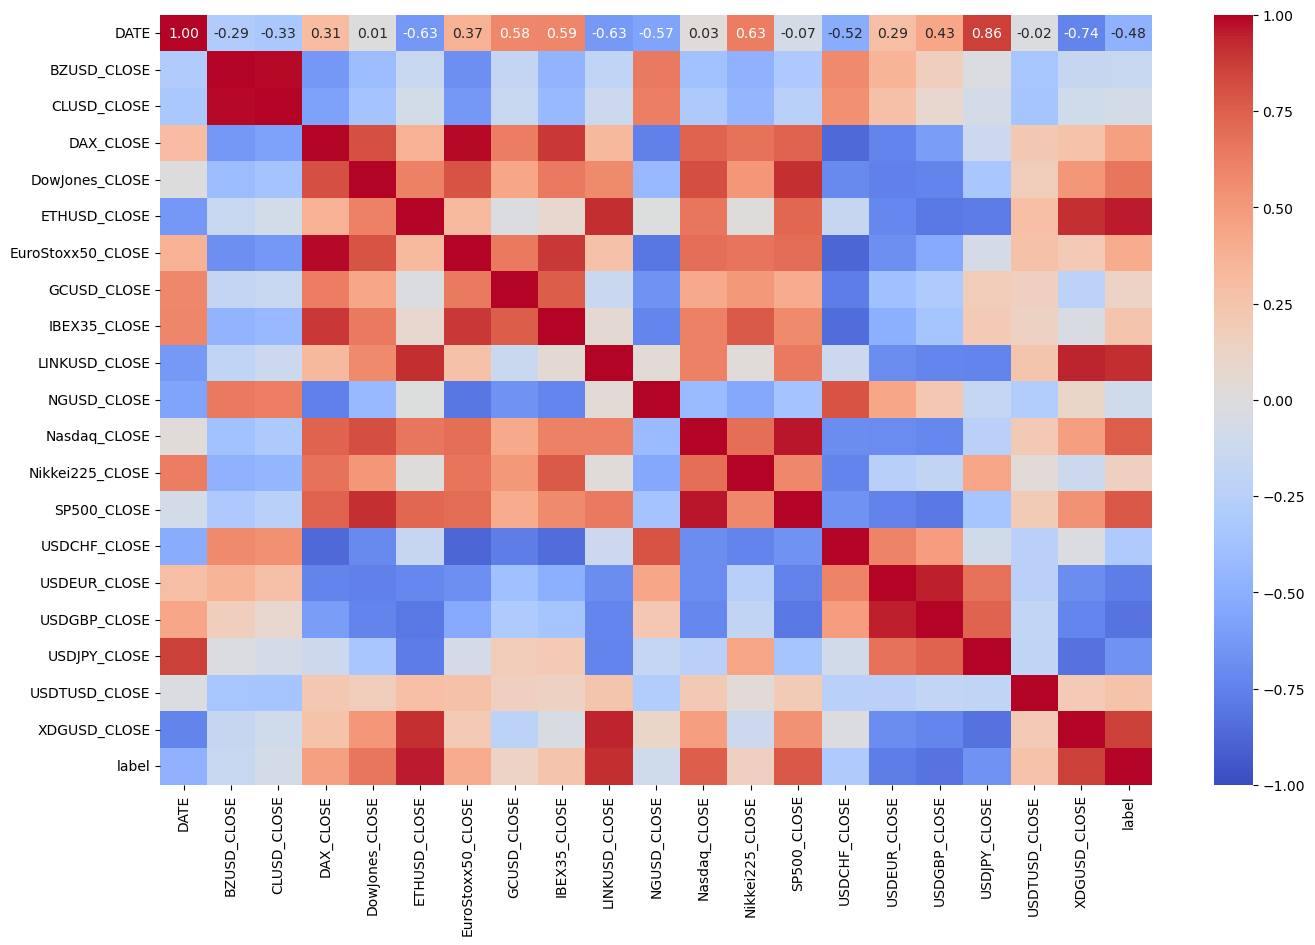

In [13]:
# Crear una matriz de correlación
corr_matrix = df_filtered_BTC.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 10))  # Ajusta el tamaño según sea necesario

# Crear el heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

# Mostrar el heatmap
plt.show()


Vemos claramente como el precio del BTC tiene una correlación negativa con el forex, correla positivamente con los indices NASDAQ y SP500, y levemente con el precio del oro. 

C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\3147620822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_BTC['DATE'] = pd.to_datetime(df_filtered_BTC['DATE'])


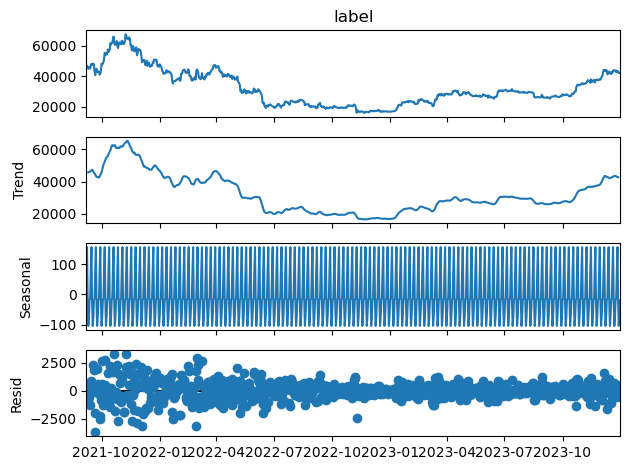

In [14]:
# Convertir la columna DATE a formato datetime si aún no lo está
df_filtered_BTC['DATE'] = pd.to_datetime(df_filtered_BTC['DATE'])

# Establecer la columna DATE como índice y asegurarnos de que tenga una frecuencia establecida
df_filtered_BTC.set_index('DATE', inplace=True)
df_filtered_BTC = df_filtered_BTC.asfreq('D')  # Suponiendo que la frecuencia es diaria. Ajusta si es necesario.

# Realizar la descomposición de la serie temporal
decomposition = seasonal_decompose(df_filtered_BTC['label'], model='additive')

# Representar la descomposición
decomposition.plot()
plt.show()

Vemos que la serie tiene estacionalidad por lo que vamos a necesitar realizar un modelo Sarimax para tratar la estacionalidad y poder meter variables exogenas
para verificar si la serie es estacionaria aplicamos el Test de Dickey-Fuller a la tendencia

In [15]:
sts.adfuller(decomposition.trend.dropna())

(-1.5154581156411755,
 0.5258510430378116,
 20,
 819,
 {'1%': -3.4383596631852327,
  '5%': -2.865075444948184,
  '10%': -2.568652576059133},
 10689.421574480359)

Como se ve, como el resultado del test (-1.51...) es mayor que el valor del intervalo de confianza al 5% (y al 1 y al 10), no puedo rechazar la hipótesis nula, H0. Por tanto, la serie no es estacionaria.

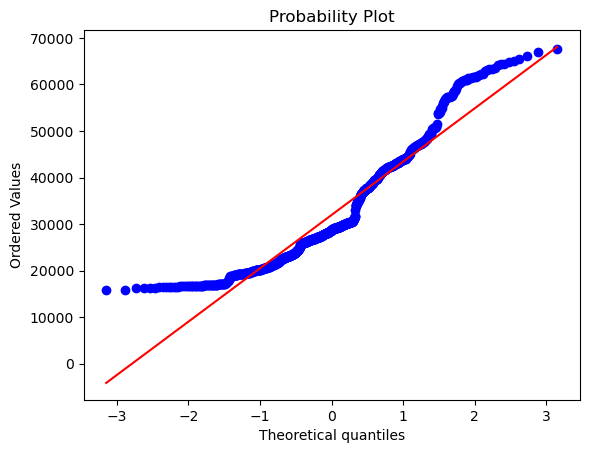

In [16]:
# Con el QQ Plot, también se puede determinar si la serie es estacionaria
scipy.stats.probplot(df_filtered_BTC['label'], plot = plt);

Como la serie no se encuentra sobre la línea, significa que no sigue una distribución normal y, por tanto, se comprueba de nuevo que la serie no es estacionaria.

Ahora, hay que descomponer la componente de tendencia para poder determinar p, d y q del modelo ARIMA (P, D y Q no es necesario, ya que no se aprecia componente de estacionalidad en la serie temporal).

In [17]:
# Se eliminan los nulos de la tendencia, estacionalidad y residuos
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

**COMPONENTE DE TENDENCIA**

In [18]:
# Se hace el test de Dickey-Fuller para ver si es estacionaria la tendencia
sts.adfuller(trend)

(-1.5154581156411755,
 0.5258510430378116,
 20,
 819,
 {'1%': -3.4383596631852327,
  '5%': -2.865075444948184,
  '10%': -2.568652576059133},
 10689.421574480359)

Como el resultado del test (-1.51...) es mayor que el valor del intervalo de confianza al 5% (y al 1%), no se puede rechazar la hipótesis nula. Por tanto, hay que diferenciar la tendencia hasta conseguir que sea estacionaria.

In [19]:
# Como la tendencia no es estacionaria, se diferencia
trend_diff = trend.diff()[1:]
sts.adfuller(trend_diff)

(-4.290061770578719,
 0.00046214845807430414,
 21,
 817,
 {'1%': -3.438379332805805,
  '5%': -2.865084115496387,
  '10%': -2.5686571948451586},
 10630.178985967068)

Se observa que la tendencia ya es estacionaria (d = 1 si se pasa la tendencia sin diferenciar).

**COMPONENTE DE ESTACIONALIDAD:**
Como se ha comentado anteriormente, al fijar la frecuencia como diaria, no se aprecia estacionalidad en la serie temporal. El modelo a emplear será el ARIMA.

**COMPONENTE DE RESIDUOS**

In [20]:
# Test de Dickey-Fuller para saber si los residuos son ruido blanco
sts.adfuller(residual)

(-11.132465075896302,
 3.2563614990098674e-20,
 20,
 819,
 {'1%': -3.4383596631852327,
  '5%': -2.865075444948184,
  '10%': -2.568652576059133},
 12926.82912303873)

No se puedo rechazar la hipótesis nula. Por tanto, se comprueba que los residuos son estacionarios y, por tanto, se puede modelar como ruido blanco (no aporta información a mi modelo).

**Autocorrelación (ACF) de la tendencia**

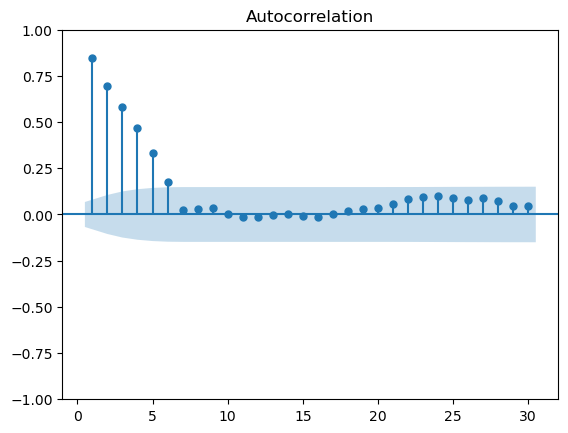

In [21]:
# Cálculo de autocorrelación para determinar q (como se usa la tendencia diferenciada, d = 0)
sgt.plot_acf(trend_diff, zero = False);

Como hay 6 palos antes de que el primero se encuentre dentro de la zona sombreada (que es el intervalo de confianza), q = 6.

**Autocorrelación parcial (PACF) de la tendencia**

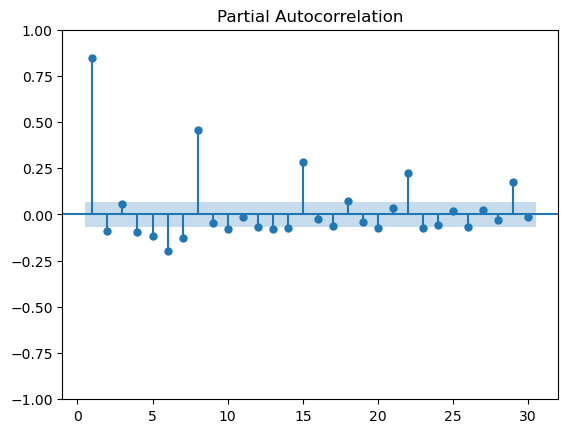

In [22]:
# Cálculo de autocorrelación parcial para determinar p (como se usa la tendencia diferenciada, d = 0)
sgt.plot_pacf(trend_diff, zero = False);

Como hay un palo antes de que el primero se encuentre en el límite del intervalo de confianza, p = 2.

Para la estacionalidad no es necesario estudiar el correlograma y el correlagrama parcial, ya que no se aprecia componente de estacionalidad en la serie temporal.

Ya se han determinado los parámetros del modelo ARIMA a utilizar: p = 2, d = 1 y q = 6. Se procede ahora a dividir el dataset en train y test:

In [23]:
train = df_filtered_BTC[:592]
test = df_filtered_BTC[592:]

Text(0, 0.5, 'label')

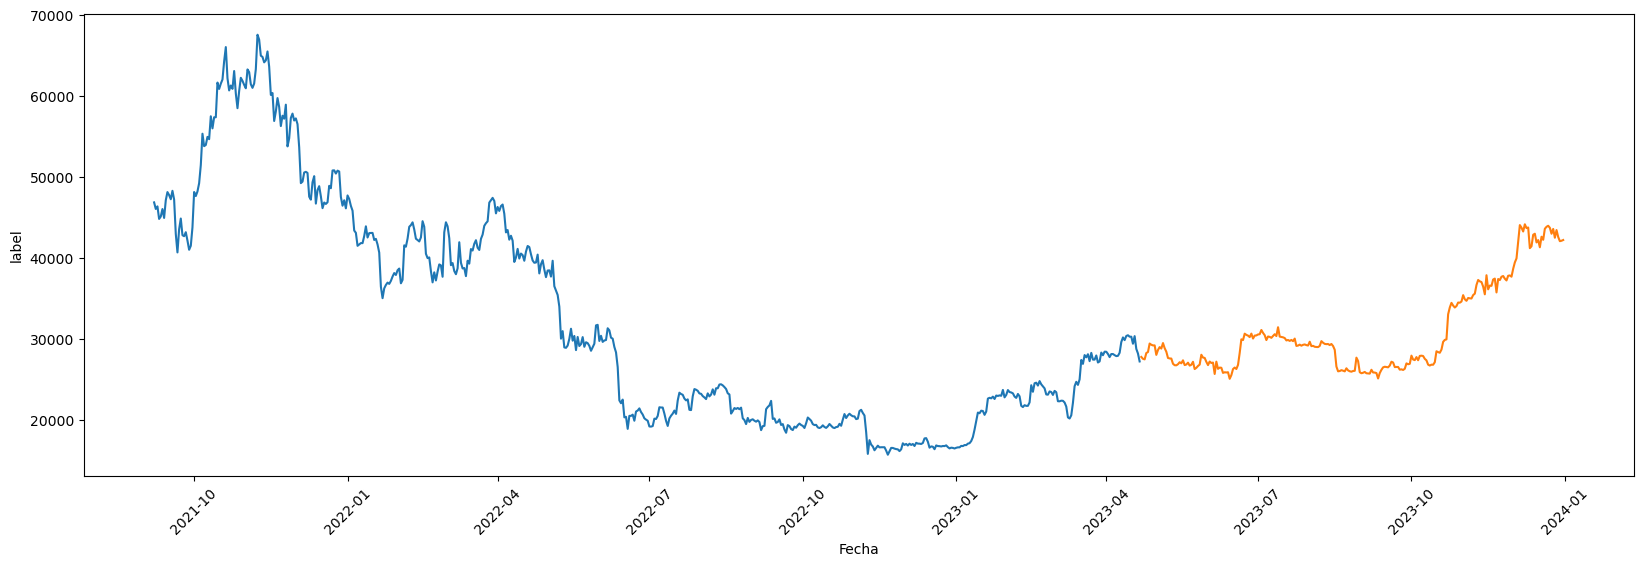

In [24]:
plt.figure(figsize=(20, 6))
plt.plot(train["label"])
plt.plot(test["label"])
plt.xticks(rotation = 45)
plt.xlabel("Fecha")
plt.ylabel("label")

In [25]:
from statsmodels.tsa.arima.model import ARIMA
modeloARIMA =ARIMA (train["label"], order=(2, 1, 6))
                        
resultados = modeloARIMA.fit()

In [26]:
inicio_prediccion = len(train)
fin_prediccion = len(test)
test["prediccion"] = resultados.predict(
    start=inicio_prediccion-1,
    end=inicio_prediccion + fin_prediccion)

C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\91361092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediccion"] = resultados.predict(


Text(0, 0.5, 'label')

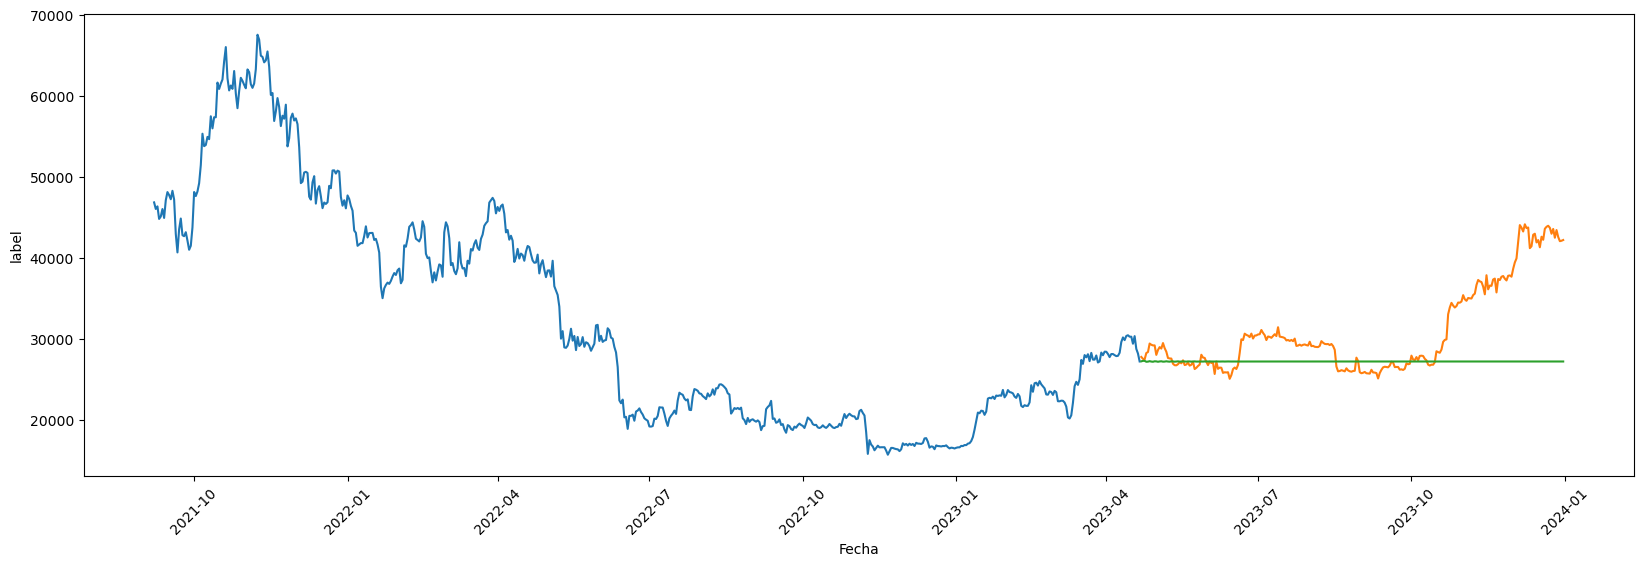

In [27]:
plt.figure(figsize=(20, 6))
plt.plot(train["label"])
plt.plot(test["label"])
plt.plot(test["prediccion"])
plt.xticks(rotation = 45)
plt.xlabel("Fecha")
plt.ylabel("label")

Comprobamos que el modelo ARIMA no es capaz de adaptarse utilizando la estructura interna de la serie temporal, vamos a probar un modelo ARIMAX para incluir vairbales exogenas.

In [28]:
# Cálculo del RMSE del modelo ARIMA utilizado
rmse = mean_squared_error(test["label"], test["prediccion"], squared = False)
print(f"Root mean squared error: {rmse}")

Root mean squared error: 6563.5784309273


In [29]:
# Se define y entrena el modelo ARIMAX (SARIMAX sin estacionalidad)
modelo_ARIMAX_1 = SARIMAX(train["label"], exog = train[["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]], order = (2, 1, 6))
ARIMAX_1 = modelo_ARIMAX_1.fit()

In [30]:
# Verificar si hay NaNs o inf en las variables exógenas
print(test[["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]].isna().sum())  # Para NaNs
print(np.isinf(test[["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]]).sum())  # Para inf


SP500_CLOSE     2
GCUSD_CLOSE     2
Nasdaq_CLOSE    2
USDEUR_CLOSE    0
dtype: int64
SP500_CLOSE     0
GCUSD_CLOSE     0
Nasdaq_CLOSE    0
USDEUR_CLOSE    0
dtype: int64


In [31]:
# Rellenar los valores NaN en las variables exógenas con forward fill
test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]] = test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].fillna(method='ffill')

# Si quedan NaNs al principio, usa backward fill
test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]] = test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].fillna(method='bfill')

# Verificar si aún hay valores NaN
print(test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].isna().sum())  # Esto debería devolver 0 si todos los NaN han sido rellenados


Nasdaq_CLOSE    0
SP500_CLOSE     0
GCUSD_CLOSE     0
dtype: int64


C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\806955227.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]] = test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].fillna(method='ffill')
C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\806955227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]] = test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].fillna(method='ffill')
C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\806955227.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.b

In [32]:
print(test[["SP500_CLOSE", "GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]].shape)


(254, 4)


In [33]:
# Se realizan las predicciones con el modelo entrenado
test["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"] = ARIMAX_1.predict(start = inicio_prediccion-1, end = inicio_prediccion-1 + fin_prediccion, exog = test[["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]].values.reshape(254,4))

C:\Users\bako6\AppData\Local\Temp\ipykernel_21708\3543883872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"] = ARIMAX_1.predict(start = inicio_prediccion-1, end = inicio_prediccion-1 + fin_prediccion, exog = test[["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]].values.reshape(254,4))


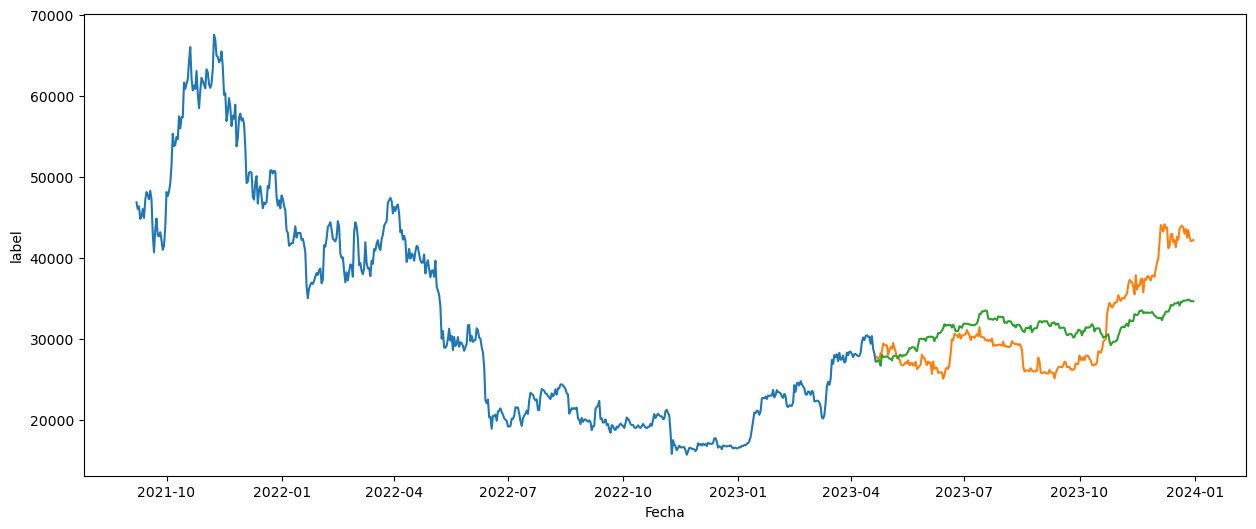

In [34]:
# Se representa gráficamente la predicción realizada con el modelo entrenado
plt.figure(figsize = (15, 6))
plt.plot(train["label"])
plt.plot(test["label"])
plt.plot(test["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"])
plt.xlabel("Fecha")
plt.ylabel("label")
plt.show();

In [35]:
# Cálculo del RMSE del modelo ARIMAX utilizado
rmse = mean_squared_error(test["label"], test["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"], squared = False)
print(f"Root mean squared error: {rmse}")

Root mean squared error: 4582.982661127702


In [36]:
wape = ((test["SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"] -
         test["label"]).abs().sum()/
        test["label"].abs().sum()) * 100
print(f"El error WAPE es de: {wape}%")

El error WAPE es de: 12.679574889434326%


In [37]:
#import pickle

# Guardar el modelo entrenado en un archivo .pkl
#with open('modelo_arimax_BTC.pkl', 'wb') as f:
    #pickle.dump(ARIMAX_1, f)
